In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1. GPT-4 Vision API 이해하기
GPT-4 Vision API는 이미지 입력과 텍스트 프롬프트를 받아 이미지에 대한 상세한 설명이나 질문에 대한 답변을 생성해 줍니다. 이를 통해 이미지 캡셔닝, 장면 이해 등 다양한 작업에 활용할 수 있습니다.

In [ ]:
!pip install openai av matplotlib pillow tqdm

import av
import openai
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import time
import base64
import re
import json
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 52.8 MB/s eta 0:00:00


In [ ]:
# OpenAI API 키 설정
OPENAI_KEY = # 실제 API 키로 대체하세요


In [ ]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_KEY)

In [ ]:
def read_video_pyav(container, frame_indices):
    frames = []  # 추출된 프레임을 저장할 리스트 초기화
    frame_counter = 0  # 현재 프레임 번호를 추적하기 위한 카운터 초기화
    frame_indices_set = set(frame_indices)  # 빠른 검색을 위해 프레임 인덱스 목록을 집합(set)으로 변환

    # 비디오 컨테이너로부터 프레임을 순차적으로 디코딩
    for frame in container.decode(video=0):
        # 현재 프레임 번호가 추출 대상 프레임 인덱스에 포함되어 있는지 확인
        if frame_counter in frame_indices_set:
            # 프레임을 RGB 포맷의 NumPy 배열로 변환
            img = frame.to_rgb().to_ndarray()
            # 변환된 이미지를 프레임 리스트에 추가
            frames.append(img)
            # 모든 대상 프레임을 추출했으면 루프 종료
            if len(frames) == len(frame_indices):
                break
        # 다음 프레임으로 이동하기 위해 카운터 증가
        frame_counter += 1

    # 추출된 프레임들을 NumPy 배열로 반환
    return np.array(frames)



```
system_instruction = """
Analyze the input online presentation video to evaluate the presenter’s non-verbal behaviors, and provide feedback based on the following five categories. For each category, identify any inappropriate behaviors exhibited by the presenter, describe the strengths and areas for improvement in a specific manner, and include concrete examples whenever possible. Additionally, ensure that feedback for each item is provided in 1-2 lines and include the corresponding problematic behavior keyword if an inappropriate behavior is detected.

**Categories and Problematic Behavior Keywords:**

1. **Eye Contact**
   - **Excessive gaze shifting**: When the presenter frequently looks away from the camera or shifts their gaze too often, it disrupts connection with the audience.
   - **Irregular gaze dispersion**: Inconsistent eye contact, where the presenter glances in different directions without a consistent focus, can reduce engagement.

2. **Facial Expressions**
   - **Expressionless**: A lack of expression throughout the presentation can make it challenging for the audience to stay engaged.
   - **Excessive facial changes**: Frequent, abrupt changes in facial expressions can be distracting and reduce the effectiveness of the message.

3. **Gestures and Hand Movements**
   - **Excessive hand movements**: Constant or overly exaggerated hand movements may distract the audience from the presentation content.
   - **Unnecessary hand movements**: Movements not relevant to the content may make the presentation appear less professional.

4. **Posture and Body Language**
   - **Slouched posture**: Poor posture, such as slouching, can project a lack of confidence.
   - **Excessive movement**: Frequent shifting or large body movements may distract the audience and affect the presentation flow.

5. **Sudden Actions and Movements**
   - **Unexpected actions**: Abrupt actions or gestures without purpose can divert the audience’s attention unexpectedly.
   - **Disrupting presentation flow**: Actions that break the flow of the presentation can make it harder for the audience to follow the message.

**Feedback Format:**

- **Eye Contact**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Facial Expressions**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Gestures and Hand Movements**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Posture and Body Language**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Sudden Actions and Movements**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

**Additional Guidelines:**
- When pointing out inappropriate behaviors, provide specific examples along with suggestions for improvement.
- Include the corresponding problematic behavior keyword at the end of the "Areas for Improvement" section if an inappropriate behavior is detected.
- Balance feedback by highlighting both positive and inappropriate behaviors to maintain the presenter’s motivation.
- Explain how the presenter’s behaviors relate to the objectives of the presentation.
- Use concrete examples to enhance the clarity of the feedback.

**Examples:**

- **Eye Contact**
  - **Strengths:** "You maintained steady eye contact with the camera throughout the presentation, effectively engaging the audience."
  - **Areas for Improvement:** "You were frequently looking away from the camera during the presentation. Maintaining eye contact with the camera will facilitate better communication." [Excessive gaze shifting]

- **Facial Expressions**
  - **Strengths:** "You used appropriate facial expressions when explaining key points, which made your message clearer."
  - **Areas for Improvement:** "You appeared expressionless throughout the presentation, making it difficult to capture the audience’s interest. Try using varied facial expressions to convey emotions." [Excessive facial changes]
"""

```



In [ ]:
system_instruction = """
당신은 15년 이상의 경력을 가진 온라인 발표 전문 코치입니다. 비언어적 커뮤니케이션 분야의 전문가로서, 수많은 발표자들이 비언어적 행동을 개선하도록 도왔습니다. 당신은 발표자의 온라인 발표에서의 제스처, 표정, 시선 처리, 자세 등이 청중에게 미치는 영향을 깊이 이해하고 있으며, 이를 토대로 구체적이고 실용적인 피드백을 제공합니다.
입력된 온라인 발표 영상을 분석하여 발표자의 비언어적 행동을 평가하고, 다음 다섯 가지 카테고리를 기준으로 피드백을 제공해주세요. 각 카테고리마다 발표자가 보인 부적절한 행동을 식별하고, 개선이 필요한 점을 구체적으로 서술하며, 가능한 경우 구체적인 예시를 포함해주세요. 피드백은 각 항목당 1~2줄로 간결하게 제공되며, 부적절한 행동이 감지된 경우 해당 문제 행동의 정의 키워드를 포함시켜주세요.

추가 지침:

- 부적절한 행동을 지적할 때는 구체적인 예시와 함께 개선 방안을 제시해주세요.
- 긍정적인 행동은 제외하고, 개선이 필요한 행동에 집중하여 피드백을 제공해주세요.
- 가능한 한 구체적인 예시를 들어 피드백의 명확성을 높여주세요.
- 하나의 카테고리에서 여러 부적절한 행동이 감지될 경우 모두 언급하여 발표자가 명확하게 이해할 수 있도록 합니다.

카테고리 및 부적절한 행동 키워드:

1. 시선 처리
   - 과도한 시선 이동
     - 예시: 발표자가 중요한 내용을 설명할 때마다 자주 화면 밖을 보거나 주변을 둘러보며 시선을 지속적으로 이동합니다.
     - 감지 기준:
       - 발표자의 눈이 카메라를 바라보지 않고 다른 곳을 응시함.
   - 불규칙한 시선 분산
     - 예시: 발표 중간중간 시선을 갑자기 왼쪽, 오른쪽, 아래 등 다양한 방향으로 자주 돌려 일관된 시선 유지를 하지 못합니다.
     - 감지 기준:
       - 시선을 특정 지점에 지속적으로 유지하지 못하고 불규칙하게 움직임.

2. 얼굴 표정
   - 무표정
     - 예시: 발표 내내 무표정을 유지하여 감정을 전달하지 못해 청중의 관심을 끌기 어렵습니다.
     - 감지 기준:
       - 발표 시간의 80% 이상 동안 얼굴에 변화가 거의 없음.
   - 과도한 표정 변화
     - 예시: 발표 도중 지나치게 많은 표정 변화를 보여 자연스럽지 않고 산만하게 보입니다.
     - 감지 기준:
       - 표정이 자주 변하여 청중의 집중을 방해함.

3. 제스처 및 손동작
   - 과도한 손동작
     - 예시: 발표 하는 도중에 갑자기 화면에 손이 나오거나, 손을 흔들거나 움직여 청중의 집중을 방해합니다.
     - 감지 기준:
       - 발표 내용과 관련 없는 손동작으로 청중의 주의를 분산시킴.
   - 불필요한 손동작
     - 예시: 발표 내용과 관련 없는 손동작을 반복적으로 사용하여 산만하게 만듭니다. 예를 들어, 설명과 무관하게 손을 계속해서 얼굴 가까이로 가져갑니다.
     - 감지 기준:
       - 손동작이 발표의 흐름과 무관하게 이루어져 청중의 집중을 방해함.

4. 자세 및 신체 언어
   - 구부정한 자세
     - 예시: 발표자가 자세를 바르게 하지 않고 고개를 숙이면서 청중의 집중을 방해합니다.
     - 감지 기준:
       - 갑자기 숙임, 화면을 벗어나는등 비전문적인 자세.
   - 과도한 움직임
     - 예시: 발표 중 자리에서 일어나거나, 몸을 좌우 앞뒤로 크게 움직여 발표의 흐름을 방해합니다.
     - 감지 기준:
       - 발표 화면내에서 허리와 등을 곧게 펴지 않는 자세
       - 발표의 흐름을 방해하고 청중의 집중을 흐트러뜨림.

5. 갑작스러운 행동 및 움직임
   - 예상치 못한 행동
     - 예시: 발표 도중 갑자기 손을 크게 올리거나, 몸을 급격하게 돌리는 등 예측할 수 없는 행동을 합니다. 예를 들어, 중요한 포인트 없이 갑자기 손을 크게 흔듭니다.
     - 감지 기준:
       - 발표 중 발표화면에서 발표자의 예상치 못한 행동이 발생.
       - 청중의 주의를 갑작스럽게 분산시켜 발표의 일관성을 해침.
   - 발표 흐름 방해
     - 예시: 발표 중 중요한 내용을 설명할 때 갑자기 손을 올려 청중의 주의를 분산시킵니다. 예를 들어, 슬라이드를 설명하는 도중에 불필요하게 손을 크게 움직입니다.
     - 감지 기준:
       - 발표 화면에서 발표 흐름을 방해하는 행동이 발생.
       - 발표의 일관성을 유지하지 못하고 청중의 집중을 분산시킴.

피드백 형식:

- 시선 처리
  - 개선이 필요한 점: "발표 중간에 자주 화면 밖을 보시는 모습이 관찰되었습니다. 카메라를 향해 시선을 유지하시면 더 효과적인 소통이 가능할 것입니다." [과도한 시선 이동]
  - 권장 사항: "카메라와 시선을 고정하여 청중과 일관된 연결을 유지하도록 연습해 보세요."

- 얼굴 표정
  - 개선이 필요한 점: "발표 내내 무표정하게 보이는 부분이 있어 청중의 관심을 끌기 어려웠습니다. 다양한 표정을 사용하여 감정을 표현해보세요." [무표정]
  - 권장 사항: "강조할 때나 중요한 순간에 미소나 표정 변화를 추가하면 더 생동감 있는 발표가 될 것입니다."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 도중 손을 너무 많이 흔드셔서 산만하게 보일 수 있었습니다. 주요 포인트에서만 손동작을 사용해보시면 좋겠습니다." [과도한 손동작]
  - 권장 사항: "핵심 포인트에만 손동작을 사용하여 발표의 주목도를 높여 보세요."

- 자세 및 신체 언어
  - 개선이 필요한 점: "발표 중간에 자주 자세가 바뀌는 모습이 보였습니다. 안정된 자세를 유지하시면 더욱 집중된 발표가 될 것입니다." [구부정한 자세]
  - 권장 사항: "앉거나 서 있을 때 몸을 일직선으로 유지해 안정감 있는 인상을 주도록 해보세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 도중 예상치 못한 손동작을 자주 사용하셨습니다. 손동작을 좀 더 계획적으로 사용하시면 좋을 것 같습니다." [예상치 못한 행동]
  - 권장 사항: "강조가 필요할 때만 움직임을 추가하여 청중의 집중을 유도하세요."


"""


In [ ]:
# 문제 행동의 정의 키워드 목록
PROBLEMATIC_BEHAVIORS = [
    "과도한 시선 이동",
    "불규칙한 시선 분산",
    "무표정",
    "과도한 표정 변화",
    "과도한 손동작",
    "불필요한 손동작",
    "구부정한 자세",
    "과도한 움직임",
    "예상치 못한 행동",
    "발표 흐름 방해"
]

In [ ]:
# 사용자 프롬프트 생성 함수
def generate_user_prompt(img_type, img_b64_str):
    """
    주어진 이미지 데이터와 타입을 기반으로 비언어적 행동 평가를 요청하는 사용자 프롬프트를 생성합니다.
    """
    return f"Please evaluate the presenter's non-verbal behavior.\n\nImage data: data:{img_type};base64,{img_b64_str}"


In [ ]:
# 이미지 인코딩 함수
def encode_image(image, max_size=(256, 256), quality=70):
    """
    이미지를 리사이즈하고 JPEG 형식으로 인코딩한 후 Base64 문자열로 반환합니다.

    Parameters:
    - image: PIL.Image 형식의 이미지
    - max_size: 이미지의 최대 크기 (기본값: 256x256)
    - quality: JPEG 압축 품질 (기본값: 70)

    Returns:
    - Base64로 인코딩된 이미지 문자열
    """
    # 이미지 리사이즈
    image.thumbnail(max_size)
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG", quality=quality)
    img_b64_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_b64_str


In [ ]:
# 비디오 길이 가져오기 함수
def get_video_duration(video_path):
    """
    주어진 비디오 파일의 전체 길이(초 단위)를 반환합니다.

    Parameters:
    - video_path: 비디오 파일 경로

    Returns:
    - 비디오 길이 (초 단위)
    """
    try:
        container = av.open(video_path)
        stream = container.streams.video[0]
        duration = stream.duration * stream.time_base
        container.close()
        return duration
    except Exception as e:
        print(f"비디오 길이 가져오기 실패: {e}")
        return 0


In [ ]:
# 비디오에서 프레임 추출 함수
def download_and_sample_video_local(video_path, start_time=0, duration=60, frame_interval=3):
    """
    주어진 비디오 파일에서 지정된 시작 시간과 지속 시간 내에서 일정 간격으로 프레임을 추출합니다.

    Parameters:
    - video_path: 비디오 파일 경로
    - start_time: 추출 시작 시간 (초 단위)
    - duration: 추출할 구간의 길이 (초 단위)
    - frame_interval: 프레임 추출 간격 (초 단위)

    Returns:
    - 추출된 프레임들의 리스트 (NumPy 배열 형식)
    """
    try:
        # 비디오 파일 열기
        container = av.open(video_path)
    except FileNotFoundError:
        print(f"비디오 파일을 찾을 수 없습니다: {video_path}")
        return None
    except av.AVError as e:
        print(f"비디오 파일을 여는 중 오류가 발생했습니다: {e}")
        return None

    stream = container.streams.video[0]
    fps = float(stream.average_rate) if stream.average_rate else 30.0

    # 세그먼트 내에서 추출할 프레임의 타임스탬프 계산
    num_frames = int(duration / frame_interval) + 1
    timestamps = [
        start_time + i * frame_interval
        for i in range(num_frames)
        if start_time + i * frame_interval <= start_time + duration
    ]

    frames = []
    index = 0
    seek_pts = int(start_time / stream.time_base)
    container.seek(seek_pts, any_frame=False, backward=True, stream=stream)

    for frame in container.decode(video=0):
        frame_time = frame.time
        if frame_time is None:
            continue
        if frame_time < start_time:
            continue
        if frame_time >= start_time + duration:
            break

        while index < len(timestamps) and frame_time >= timestamps[index]:
            frames.append(frame.to_rgb().to_ndarray())
            index += 1
            if index >= len(timestamps):
                break

    container.close()
    return np.array(frames)


In [ ]:
def analyze_frames(frames, segment_idx, duration, segment_length, frame_interval=3):
    problematic_frames = []
    feedbacks = []

    PROBLEMATIC_BEHAVIORS = [
        "과도한 시선 이동",
        "불규칙한 시선 분산",
        "무표정",
        "과도한 표정 변화",
        "과도한 손동작",
        "불필요한 손동작",
        "구부정한 자세",
        "과도한 움직임",
        "예상치 못한 행동",
        "발표 흐름 방해"
    ]

    num_frames = len(frames)
    time_stamps = [
        segment_idx * segment_length + i * frame_interval
        for i in range(num_frames)
    ]

    for i, (frame, frame_time_sec) in enumerate(zip(frames, time_stamps)):
        minutes = int(frame_time_sec // 60)
        seconds = int(frame_time_sec % 60)
        timestamp = f"{minutes}m {seconds}s"

        # 사용자 프롬프트 생성
        user_prompt = (
            "다음 이미지에서 발표자의 비언어적 행동을 분석하고, system_instruction 내용에 기반해서 문제가 되는 행동이 있으면 피드백을 제공해주세요. "
            "문제가 없으면 '문제 없음'이라고 답해주세요."
        )

        img_type = "image/jpeg"

        # 이미지를 인코딩
        image = Image.fromarray(frame)
        img_b64_str = encode_image(image)

        # 사용자 메시지 구성
        user_message = f"{user_prompt}\n\n이미지 데이터: data:{img_type};base64,{img_b64_str}"

        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",  # 사용 가능한 모델 이름으로 설정
                messages=[
                    {
                        "role": "system",
                        "content": system_instruction
                    },
                    {
                        "role": "user",
                        "content": user_message
                    }
                ],
                max_tokens=600,
            )

            # 생성된 텍스트와 문제 행동 추출
            generated_text = response.choices[0].message.content
            behaviors_detected = re.findall(r'\[([^\[\]]+)\]', generated_text)

            # 공백 제거
            behaviors_detected = [behavior.strip() for behavior in behaviors_detected]

            # 디버깅을 위해 감지된 문제 행동 출력
            print(f"[디버그] 프레임 {i+1} 응답 텍스트: {generated_text}")
            print(f"[디버그] 감지된 문제 행동: {behaviors_detected}")
            print(f"[디버그] PROBLEMATIC_BEHAVIORS 리스트: {PROBLEMATIC_BEHAVIORS}")

            # 문제 행동 감지 여부 확인
            problem_detected = any(behavior in PROBLEMATIC_BEHAVIORS for behavior in behaviors_detected)

            if problem_detected:
                # 프레임과 세그먼트 정보를 저장
                problematic_frames.append((frame, segment_idx + 1, i + 1, timestamp))
                feedbacks.append(generated_text)

        except Exception as e:
            print(f"프레임 {i+1} 처리 중 오류 발생: {e}")

    return problematic_frames, feedbacks


In [ ]:
def plot_problematic_frames(frames, feedbacks):
    if not frames:
        print("문제 있는 프레임이 없습니다.")
        return

    for i, (frame_info, feedback) in enumerate(zip(frames, feedbacks)):
        frame, segment_number, frame_number, timestamp = frame_info

        # 피드백을 콘솔에 출력
        print(f"Segment {segment_number}, Frame {frame_number} ({timestamp})")
        print("피드백:")
        print(feedback)
        print("-" * 50)

        # 이미지 표시
        plt.figure(figsize=(8, 6))
        plt.imshow(frame)
        plt.title(f"Segment {segment_number}, Frame {frame_number} ({timestamp})", fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


In [ ]:
def main():
    video_path = "/content/drive/MyDrive/kakaotech-14-ai/test_video2.mp4"  # 비디오 파일의 경로
    segment_length = 60  # 각 세그먼트의 길이 (초 단위)
    frame_interval = 3   # 프레임 추출 간격 (초 단위)

    # 비디오의 전체 길이(초 단위)를 가져옵니다.
    video_duration = get_video_duration(video_path)

    # 비디오를 세그먼트로 분할하기 위한 세그먼트 수 계산
    num_segments = math.ceil(video_duration / segment_length)
    print(f"비디오 전체 길이: {int(video_duration // 60)}분 {int(video_duration % 60)}초")
    print(f"총 {num_segments}개의 세그먼트로 분할됩니다.")

    all_segments_frames = []  # 모든 세그먼트의 프레임들을 저장할 리스트
    all_durations = []        # 각 세그먼트의 지속 시간을 저장할 리스트

    # 각 세그먼트별로 프레임을 추출합니다.
    for i in range(num_segments):
        start_time = i * segment_length  # 현재 세그먼트의 시작 시간 (초 단위)

        # 마지막 세그먼트의 지속 시간을 조정합니다.
        if i == num_segments - 1:
            duration = video_duration - start_time  # 남은 시간을 지속 시간으로 설정
        else:
            duration = segment_length  # 세그먼트 길이를 지속 시간으로 설정

        all_durations.append(duration)  # 세그먼트의 지속 시간을 저장

        print(f"샘플링 중인 세그먼트 {i+1}/{num_segments} (시작 시간: {int(start_time // 60)}분 {int(start_time % 60)}초)")

        # 해당 세그먼트에서 프레임을 추출합니다.
        clip = download_and_sample_video_local(
            video_path, start_time=start_time, duration=duration, frame_interval=frame_interval
        )

        # 추출된 프레임이 있으면 리스트에 추가합니다.
        if clip is not None and len(clip) > 0:
            all_segments_frames.append(clip)
        else:
            print(f"세그먼트 {i+1}에서 프레임을 추출할 수 없습니다.")

    print(f"총 {len(all_segments_frames)}개의 세그먼트가 추출되었습니다.")

    all_problematic_frames = []
    all_feedbacks = []

    # 모든 세그먼트에 대해 프레임 분석을 수행합니다.
    for idx, (segment_frames, duration) in enumerate(zip(all_segments_frames, all_durations)):
        print(f"\nAnalyzing segment {idx+1}/{len(all_segments_frames)}")
        # 각 세그먼트의 프레임들을 분석합니다.
        problematic_frames, feedbacks = analyze_frames(
            segment_frames, idx, duration, segment_length, frame_interval=frame_interval
        )
        all_problematic_frames.extend(problematic_frames)
        all_feedbacks.extend(feedbacks)

    # 문제 있는 프레임들을 시각화합니다.
    plot_problematic_frames(all_problematic_frames, all_feedbacks)


비디오 전체 길이: 2분 3초
총 3개의 세그먼트로 분할됩니다.
샘플링 중인 세그먼트 1/3 (시작 시간: 0분 0초)
샘플링 중인 세그먼트 2/3 (시작 시간: 1분 0초)
샘플링 중인 세그먼트 3/3 (시작 시간: 2분 0초)
총 3개의 세그먼트가 추출되었습니다.

Analyzing segment 1/3
[디버그] 프레임 1 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 2 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 3 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 4 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 5 응답 텍스트: - 시선 처리
  - 개선이 필요한

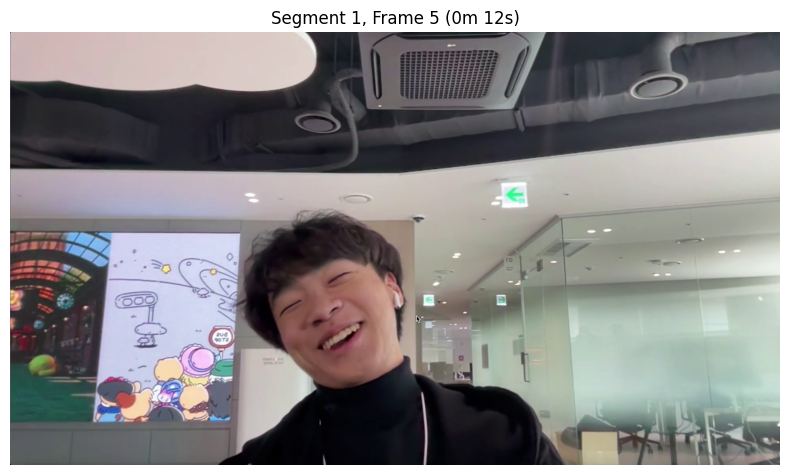

Segment 1, Frame 14 (0m 39s)
피드백:
- 시선 처리
  - 개선이 필요한 점: "발표자가 카메라를 응시하지 않고 시선이 불규칙하게 움직이는 모습이 관찰되었습니다. 청중과의 시선 연결이 끊겨 발표의 집중도가 낮아질 수 있습니다." [불규칙한 시선 분산]
  - 권장 사항: "중요한 내용 전달 시에는 카메라를 바라보며 시선을 고정하여 청중과의 연결을 강화하세요."

- 얼굴 표정
  - 개선이 필요한 점: "발표 내내 표정이 거의 변하지 않아 감정이 전달되지 않고 청중이 지루함을 느낄 수 있습니다." [무표정]
  - 권장 사항: "발표의 핵심 포인트에 감정을 담아 표정을 변화시켜 청중의 관심을 끌어보세요."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 중 손동작이 과도하게 이루어져 내용과의 관련성이 떨어지고 청중의 집중을 방해합니다." [과도한 손동작]
  - 권장 사항: "주요 포인트를 강조할 때에만 손동작을 하여 발표의 집중도를 높이도록 해보세요."

- 자세 및 신체 언어
  - 개선이 필요한 점: "발표자가 구부정한 자세로 서 있는 모습이 자주 관찰되었습니다. 이는 비전문적인 인상을 줄 수 있습니다." [구부정한 자세]
  - 권장 사항: "자세를 개선하고 허리를 곧게 펴서 안정된 모습으로 발표하세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 도중에 갑작스럽게 손을 흔드는 등 예상치 못한 행동이 빈번하게 발생하여 청중의 주의가 분산됩니다." [예상치 못한 행동]
  - 권장 사항: "핵심 주제를 강조할 때만 몸의 움직임을 추가하여 예측 가능한 발표를 만들어 보세요."
--------------------------------------------------


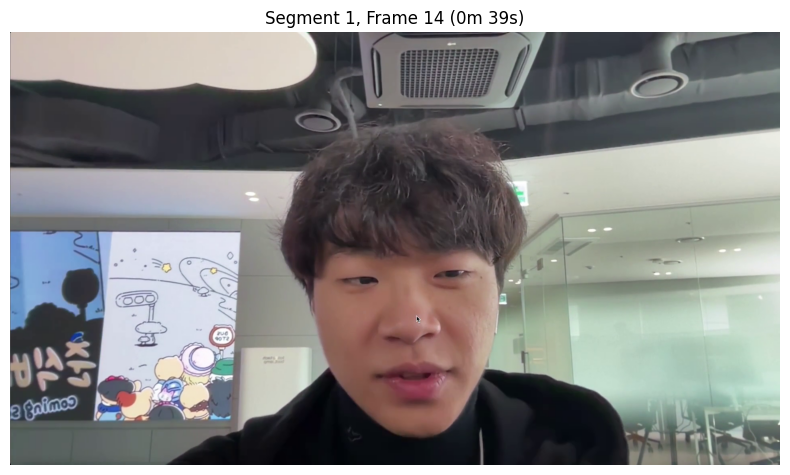

Segment 1, Frame 19 (0m 54s)
피드백:
- 시선 처리
  - 개선이 필요한 점: "발표자가 중요한 내용을 설명할 때 화면 밖을 자주 바라보는 모습이 관찰되었습니다. 카메라를 향해 시선을 유지하시면 더 효과적인 소통이 가능할 것입니다." [과도한 시선 이동]
  - 권장 사항: "카메라와 시선을 고정하여 청중과 일관된 연결을 유지하도록 연습해 보세요."

- 얼굴 표정 
  - 개선이 필요한 점: "발표 내내 무표정하게 보이는 부분이 있어 청중의 관심을 끌기 어려웠습니다. 다양한 표정을 사용하여 감정을 표현해보세요." [무표정]
  - 권장 사항: "강조할 때나 중요한 순간에 미소나 표정 변화를 추가하면 더 생동감 있는 발표가 될 것입니다."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 도중 손동작이 너무 과도하여 청중의 주의를 산만하게 할 수 있었습니다. 주요 포인트에서만 손동작을 사용해보시면 좋겠습니다." [과도한 손동작]
  - 권장 사항: "핵심 포인트에만 손동작을 사용하여 발표의 주목도를 높여 보세요."

- 자세 및 신체 언어 
  - 개선이 필요한 점: "발표 중간에 구부정한 자세를 보였으며, 이는 전문성을 떨어뜨릴 수 있습니다. 안정된 자세를 유지하시면 더욱 집중된 발표가 될 것입니다." [구부정한 자세]
  - 권장 사항: "앉거나 서 있을 때 몸을 일직선으로 유지해 안정감 있는 인상을 주도록 해보세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 도중 예상치 못한 손동작을 자주 사용하셨습니다. 손동작을 좀 더 계획적으로 사용하시면 좋을 것 같습니다." [예상치 못한 행동]
  - 권장 사항: "강조가 필요할 때만 움직임을 추가하여 청중의 집중을 유도하세요."
--------------------------------------------------


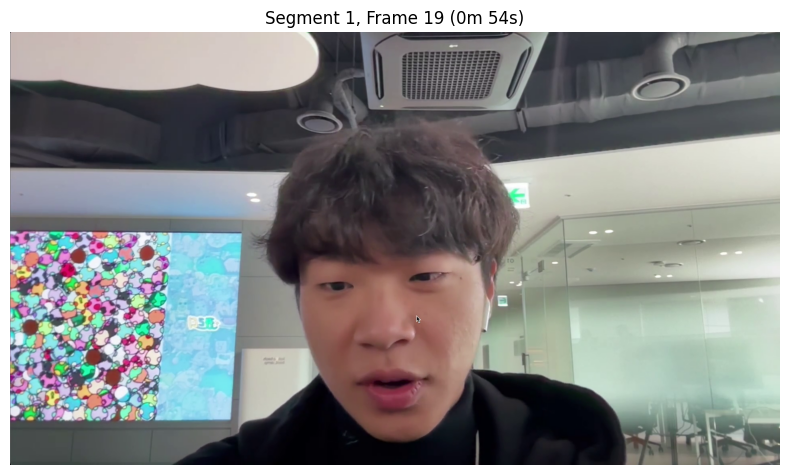

Segment 2, Frame 8 (1m 21s)
피드백:
- 시선 처리
  - 개선이 필요한 점: "발표 도중 시선이 주기적으로 좌우로 흔들리며 카메라를 바라보지 않는 모습이 관찰되었습니다. 카메라에 시선을 고정하여 청중과의 눈 맞춤을 강화해 보세요." [불규칙한 시선 분산]
  - 권장 사항: "발표의 핵심 포인트를 전달할 때는 카메라를 바라보는 연습을 통해 시선을 일관되게 유지하는 것이 중요합니다."

- 얼굴 표정 
  - 개선이 필요한 점: "발표하는 동안 얼굴 표정이 거의 변화가 없어 청중의 주의를 끌기 어려웠습니다. 감정을 더욱 적극적으로 표현해보세요." [무표정]
  - 권장 사항: "중요한 내용을 강조할 때 미소나 적절한 표정 변화를 추가하여 발표의 생동감을 높여보시길 바랍니다."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 중 손동작 사용이 불필요하게 반복되어 청중의 주의가 분산되는 모습이 보였습니다. 발표 내용과 관련된 손동작을 활용해 보세요." [불필요한 손동작]
  - 권장 사항: "주요 포인트를 설명할 때만 손동작을 사용하는 연습을 통해 발표의 집중도를 높일 수 있습니다."

- 자세 및 신체 언어 
  - 개선이 필요한 점: "발표를 할 때 구부정한 자세로 인해 비전문적인 인상을 줄 수 있습니다. 바른 자세를 유지하도록 신경 써주세요." [구부정한 자세]
  - 권장 사항: "의자에 앉거나 서 있을 때 척추를 곧게 펴고 몸을 안정적으로 유지하여 청중에게 신뢰감을 줄 수 있습니다."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 중간중간 예상치 못한 행동이 있어 청중의 주의가 분산되는 경우가 있었습니다. 불필요한 움직임은 피해주세요." [예상치 못한 행동]
  - 권장 사항: "내용을 강조할 필요가 있는 경우 기다리거나 손을 자연스럽게 사용하여 청중의 집중을 유도하세요."
--------------------------------------------------


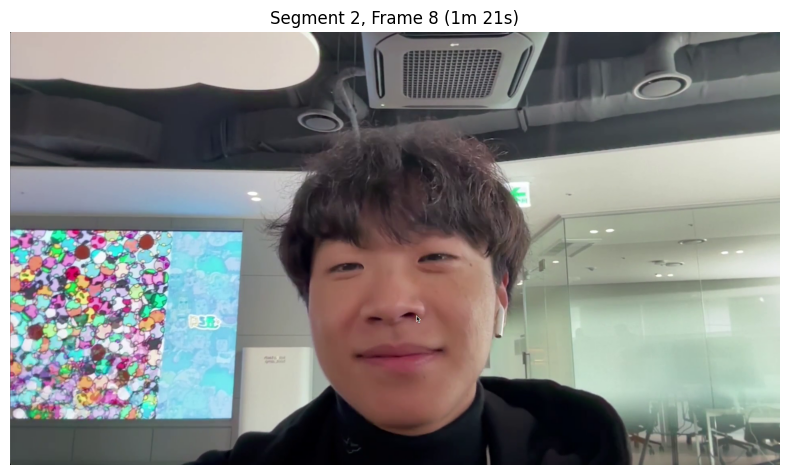

Segment 2, Frame 10 (1m 27s)
피드백:
- 시선 처리
  - 개선이 필요한 점: "발표자가 중요한 내용을 설명할 때 카메라를 바라보지 않고 다른 방향을 보는 모습이 관찰되었습니다. 카메라에 시선을 고정하면 청중과의 연결이 강화될 것입니다." [과도한 시선 이동]
  - 권장 사항: "발표 중 반드시 카메라를 주의 깊게 바라보도록 연습해 보세요."

- 얼굴 표정 
  - 개선이 필요한 점: "발표 내내 무표정하게 보여 감정을 전달하지 못해 청중의 관심을 끌기 어렵습니다." [무표정]
  - 권장 사항: "중요한 포인트에서 미소를 짓거나 표정을 변화시켜 감정을 표현해보세요."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 중 손을 너무 많이 흔들거나 불필요한 손동작을 반복하여 청중의 집중을 방해합니다." [과도한 손동작]
  - 권장 사항: "핵심 메시지를 전달할 때만 손동작을 활용하여 발표의 주목도를 높이세요."

- 자세 및 신체 언어
  - 개선이 필요한 점: "발표 중 구부정한 자세로 고개를 숙이며 청중의 집중을 방해하였습니다." [구부정한 자세]
  - 권장 사항: "앉거나 서 있을 때 몸을 곧게 펴고 안정된 자세를 유지해 보세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 도중 예상치 못한 손동작이나 급격한 몸의 움직임이 보여 청중의 주의가 분산되었습니다." [예상치 못한 행동]
  - 권장 사항: "발표 중 간결하게 의도한 행동만 포함하도록 해 청중의 집중을 유지하세요."
--------------------------------------------------


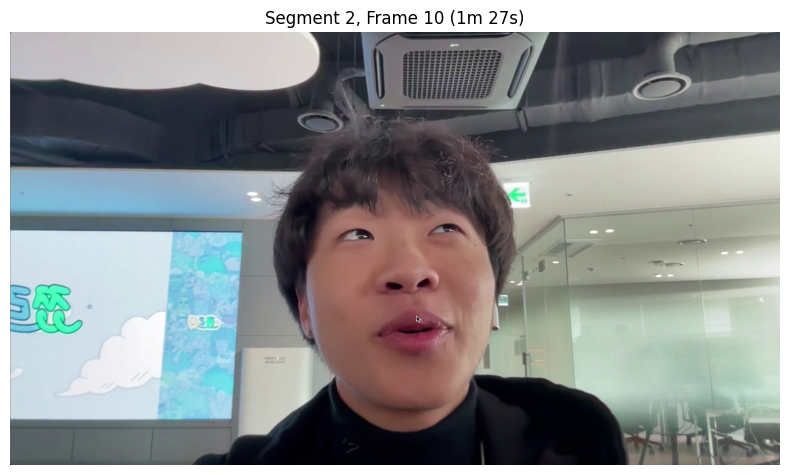

Segment 2, Frame 12 (1m 33s)
피드백:
- 시선 처리
  - 개선이 필요한 점: "발표자가 중요한 내용을 설명할 때 시선이 화면 밖으로 계속 이동하고 있습니다. 카메라를 통해 청중과의 소통을 강화하는 것이 좋습니다." [과도한 시선 이동]
  - 권장 사항: "발표 내용의 핵심 부분에서 카메라를 바라보며 청중의 반응을 확인하는 연습을 해보세요."

- 얼굴 표정
  - 개선이 필요한 점: "발표 내내 표정 변화가 거의 없어 감정을 전달하지 못하는 모습이 관찰되었습니다. 청중의 반응을 이끌기 위해서는 다양한 표정을 활용해야 합니다." [무표정]
  - 권장 사항: "중요한 포인트에서 미소를 짓거나 표정을 변화시켜 더 생동감 있는 발표를 시도해 보세요."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 도중 손동작이 너무 잦고 과도하여 청중이 집중하기 어려웠습니다. 제스처 사용을 보다 전략적으로 고려해야 합니다." [과도한 손동작]
  - 권장 사항: "핵심 메시지 전달 시 및 요점을 강조할 때만 손동작을 사용하는 것이 효과적입니다."

- 자세 및 신체 언어
  - 개선이 필요한 점: "발표 중 구부정한 자세가 관찰되었습니다. 이는 전문적인 이미지에 부정적인 영향을 미칠 수 있습니다." [구부정한 자세]
  - 권장 사항: "등을 곧게 펴고 안정적인 자세를 유지하는 연습을 통해 청중에게 자신감 있는 인상을 줄 수 있도록 노력해 보세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 도중 갑작스러운 손동작이 자주 발생해 청중의 주의를 분산시켰습니다. 이러한 움직임은 발표의 일관성을 해칠 수 있습니다." [예상치 못한 행동]
  - 권장 사항: "중요한 메시지를 전달할 때만 손이나 몸짓을 움직여 청중의 집중을 더욱 효과적으로 유도하세요."
--------------------------------------------------


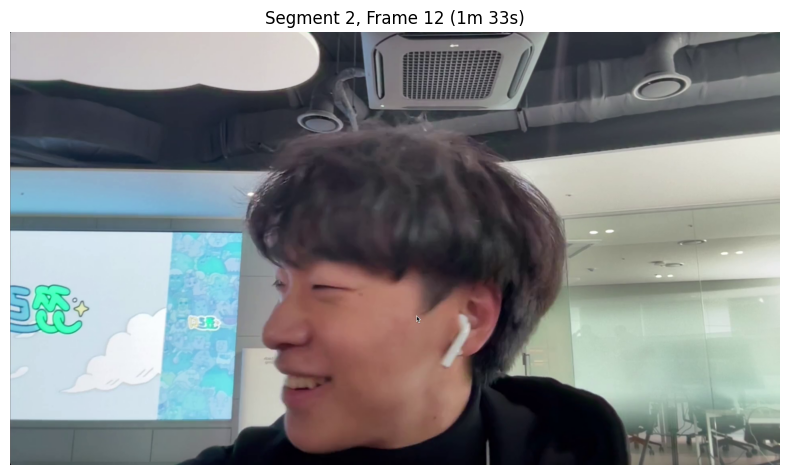

In [ ]:
if __name__ == "__main__":
    main()

ver1. 해결문제
- 정확도 이슈 (일단 정확하게 올려야 할지도 -> 파인튜닝 필요..?)
- 프레임 간격 더 줄이기 (3초 -> 1초)
- webm 형태로 제공? 이건 추후 의논 필요.